In [117]:
from sklearn.datasets import make_moons

In [119]:
X, y = make_moons(n_samples=1000, noise=0.2, random_state=42)

In [120]:
X.shape, y.shape

((1000, 2), (1000,))

In [121]:
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[-0.11166654  0.52022374]
 [ 1.14264982 -0.34257734]
 [ 0.79555796 -0.01144231]
 [ 0.11182668 -0.55193153]
 [-0.81646618  0.54399604]]

First 5 y labels:
[1 1 1 1 0]


In [122]:
# Make DataFrame of circle data
import pandas as pd
moon = pd.DataFrame({"X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
moon.head(10)

,X1,X2,label
0,-0.111667,0.520224,1
1,1.142650,-0.342577,1
2,0.795558,-0.011442,1
3,0.111827,-0.551932,1
4,-0.816466,0.543996,0
5,0.662510,-0.084356,1
6,0.274510,-0.189904,1
7,-0.115556,0.535912,1
8,1.572369,-0.335447,1
9,0.763990,0.962359,0


In [123]:
# Check different labels
moon.label.value_counts()

,count
label,
1,500
0,500


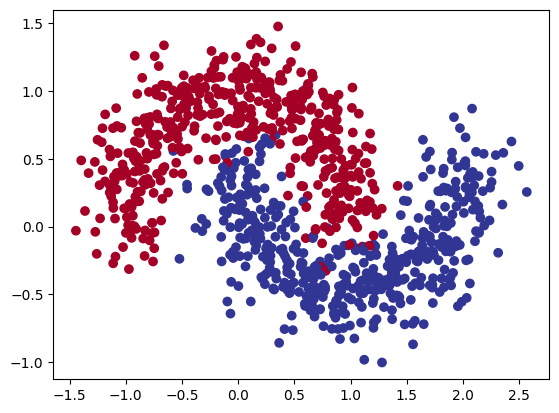

In [124]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);

In [125]:
X_sample = X[0]
y_sample = y[0]
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Shapes for one sample of X: (2,) and the same for y: ()


In [126]:
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# View the first five samples
X[:5], y[:5]

(tensor([[-0.1117,  0.5202],
         [ 1.1426, -0.3426],
         [ 0.7956, -0.0114],
         [ 0.1118, -0.5519],
         [-0.8165,  0.5440]]),
 tensor([1., 1., 1., 1., 0.]))

In [127]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [130]:
from torch import nn

# 1. Construct a model class that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling X and y input and output shapes
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features (X), produces 5 features
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features, produces 1 feature (y)

    # 3. Define a forward method containing the forward pass computation
    def forward(self, x):
        # Return the output of layer_2, a single feature, the same shape as y
        return self.layer_2(self.layer_1(x)) # computation goes through layer_1 first then the output of layer_1 goes through layer_2

# 4. Create an instance of the model and send it to target device
model_0 = CircleModelV0()
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [132]:
# Replicate CircleModelV0 with nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [134]:
# Make predictions with the model
untrained_preds = model_0(X_test)
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[ 0.1584],
        [ 0.0055],
        [-0.1939],
        [ 0.1623],
        [-0.3519],
        [-0.4980],
        [-0.0427],
        [-0.0321],
        [-0.2027],
        [ 0.2280]], grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [135]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [136]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [137]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 100


# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model_0(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls

    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train)
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.86602, Accuracy: 26.50% | Test loss: 0.82640, Test acc: 29.50%
Epoch: 10 | Loss: 0.70943, Accuracy: 52.00% | Test loss: 0.69445, Test acc: 61.00%
Epoch: 20 | Loss: 0.62821, Accuracy: 79.38% | Test loss: 0.62141, Test acc: 83.50%
Epoch: 30 | Loss: 0.55874, Accuracy: 84.62% | Test loss: 0.55678, Test acc: 85.00%
Epoch: 40 | Loss: 0.49166, Accuracy: 84.38% | Test loss: 0.49480, Test acc: 83.50%
Epoch: 50 | Loss: 0.43500, Accuracy: 84.25% | Test loss: 0.44349, Test acc: 81.00%
Epoch: 60 | Loss: 0.39449, Accuracy: 83.88% | Test loss: 0.40718, Test acc: 80.50%
Epoch: 70 | Loss: 0.36794, Accuracy: 84.00% | Test loss: 0.38306, Test acc: 81.00%
Epoch: 80 | Loss: 0.35050, Accuracy: 84.38% | Test loss: 0.36665, Test acc: 81.50%
Epoch: 90 | Loss: 0.33849, Accuracy: 84.62% | Test loss: 0.35472, Test acc: 81.00%


In [138]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

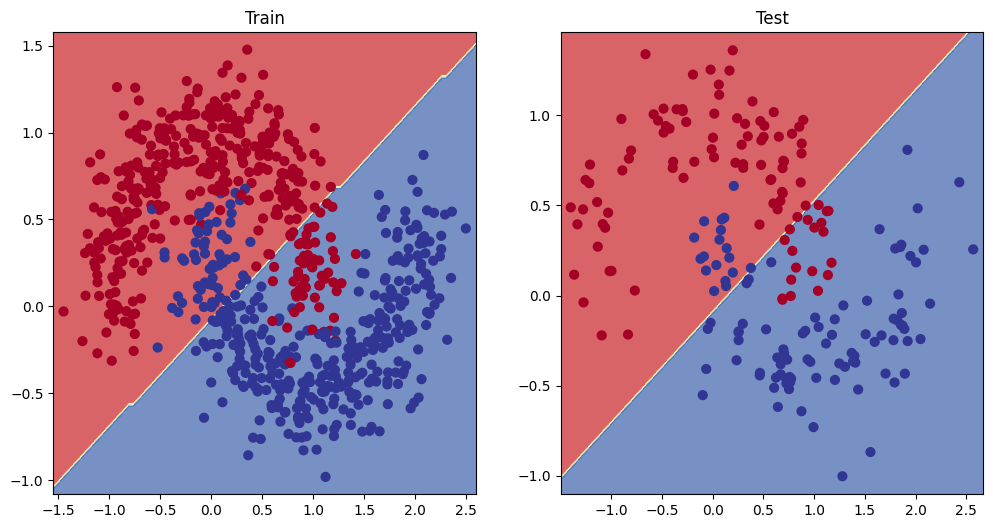

In [139]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

In [140]:
# Build model with non-linear activation function
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2()
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [141]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

In [142]:
# Fit the model
torch.manual_seed(42)
epochs = 1000

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calculate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69494, Accuracy: 39.88% | Test Loss: 0.69399, Test Accuracy: 50.50%
Epoch: 100 | Loss: 0.40633, Accuracy: 80.62% | Test Loss: 0.42149, Test Accuracy: 77.50%
Epoch: 200 | Loss: 0.28933, Accuracy: 87.25% | Test Loss: 0.28821, Test Accuracy: 85.50%
Epoch: 300 | Loss: 0.26104, Accuracy: 88.75% | Test Loss: 0.25260, Test Accuracy: 88.00%
Epoch: 400 | Loss: 0.24212, Accuracy: 89.88% | Test Loss: 0.23061, Test Accuracy: 89.00%
Epoch: 500 | Loss: 0.21760, Accuracy: 90.75% | Test Loss: 0.20313, Test Accuracy: 90.50%
Epoch: 600 | Loss: 0.18855, Accuracy: 92.25% | Test Loss: 0.17193, Test Accuracy: 92.50%
Epoch: 700 | Loss: 0.15927, Accuracy: 94.25% | Test Loss: 0.14097, Test Accuracy: 94.50%
Epoch: 800 | Loss: 0.13621, Accuracy: 95.50% | Test Loss: 0.11634, Test Accuracy: 97.00%
Epoch: 900 | Loss: 0.11959, Accuracy: 96.25% | Test Loss: 0.09877, Test Accuracy: 97.50%


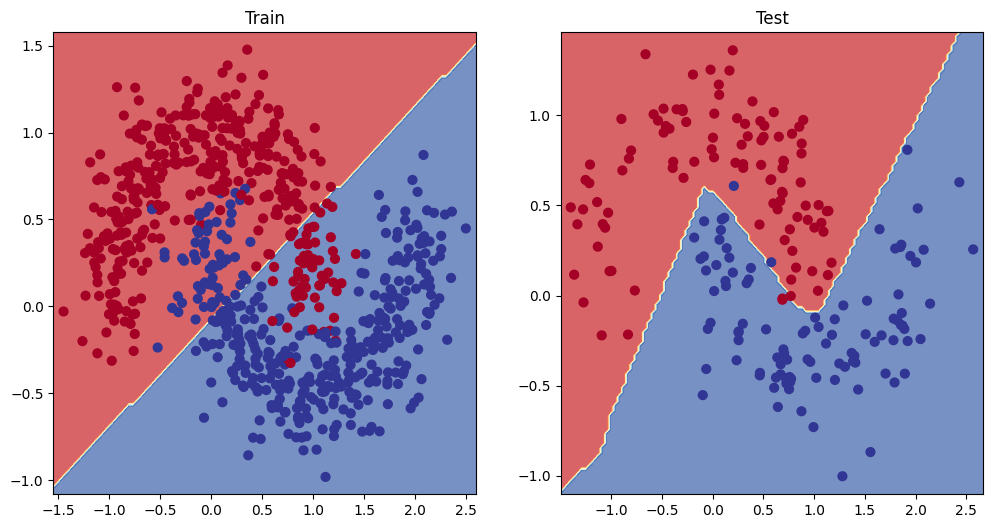

In [144]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity